In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
import numpy as np
import pandas as pd

In [68]:

from datetime import datetime as dt, timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# Declare a Base using `automap_base()`
Base = automap_base()

In [7]:
# reflect an existing database into a new model
Base.prepare(engine, reflect=True)
# reflect the tables

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
inspector = inspect(engine)

In [12]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [14]:
session.query(func.count(Measurement.date)).all()

[(19550)]

In [15]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [16]:
engine.execute('SELECT * FROM station LIMIT 10').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

## Design a query to retrieve the last 12 months of precipitation data and plot the results

In [17]:
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [18]:
# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days = 365)
year_ago

datetime.date(2016, 8, 23)

In [19]:
# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date,
      Measurement.prcp]

result = session.query(*sel).filter(func.strftime(Measurement.date) >= year_ago).all()
result[:10]

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0)]

In [20]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df=pd.DataFrame(result, columns=['date', 'precipitation'])

# Sort the dataframe by date
df.set_index('date', inplace=True)
df.sort_index(inplace=True)
df

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


Text(0, 0.5, 'Inches')

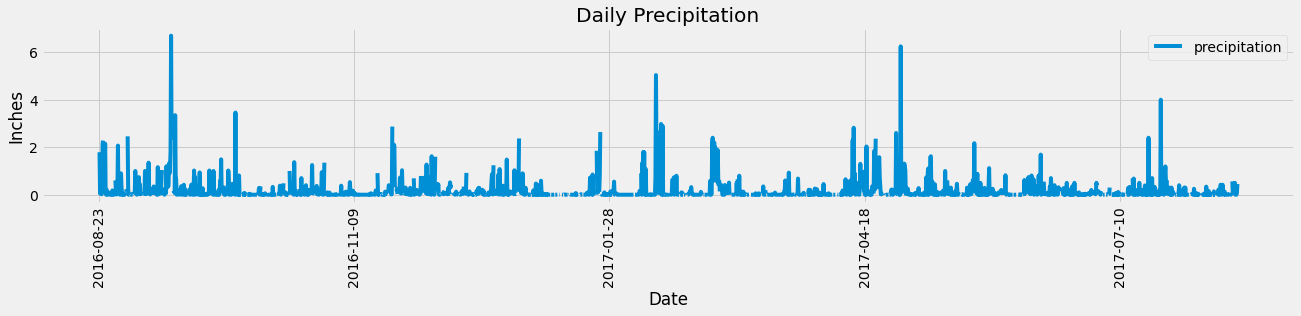

In [21]:
# Use Pandas Plotting with Matplotlib to plot the data

df.plot(rot=90, figsize =(20,3))
plt.title("Daily Precipitation")
plt.xlabel("Date")
plt.ylabel("Inches")

In [22]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [23]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [24]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active = session.query(Measurement.station, func.count(Measurement.station)).\
              group_by(Measurement.station).order_by(func.count(Measurement.station).desc())
for station in most_active:
    print(station)
most_active_station= session.query(Station.name).filter(Station.station== most_active[0][0]).all()
most_active_station

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


[('WAIHEE 837.5, HI US')]

In [25]:
print(f'The most active station is {most_active[0][0]} which had {most_active[0][1]} readings.')

The most active station is USC00519281 which had 2772 readings.


In [26]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temperatures = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max( Measurement.tobs)).\
              filter(Measurement.station == most_active[0][0])
print(f'The lowest temperature recorded was {temperatures[0][0]}, the average temperature was\
{temperatures[0][1]},and the highest temperature was {temperatures[0][2]} for station {most_active_station}.' )

The lowest temperature recorded was 54.0, the average temperature was71.66378066378067,and the highest temperature was 85.0 for station [('WAIHEE 837.5, HI US',)].


In [27]:
# Choose the station with the highest number of temperature observations.
most_obersevations = session.query(Measurement.date, Measurement.tobs).\
                    filter(Measurement.station == most_active[0][0]).\
                    filter(Measurement.date >= year_ago).all()
print(most_obersevations[0][0], most_obersevations[0][1])

2016-08-23 77.0


Text(0.5, 0, 'Temperature')

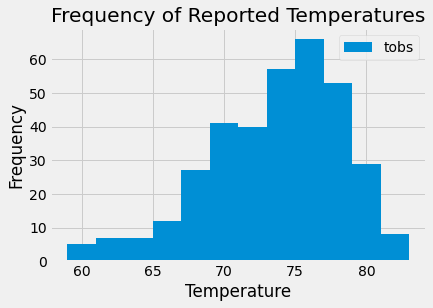

In [28]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
df_most = pd.DataFrame(most_obersevations)

df_most.plot(kind = 'hist', bins = 12)
plt.title("Frequency of Reported Temperatures")
plt.xlabel("Temperature")

## Bonus Challenge Assignment

### Temperature Analysis I

#### Identify the average temperature in June at all stations accross all available years in the dataset.

In [29]:
june_temp_avg = session.query(Measurement.date, func.avg(Measurement.tobs)).\
           filter(func.strftime("%m", Measurement.date)=="06").all()
june_temp_avg
print(f'The average temperature for the month of June from all stations over\
 all available years was {round(june_temp_avg[0][1], 2)}.')

The average temperature for the month of June from all stations over all available years was 74.94.


#### Identify the average temperature in December at all stations accross all available years in the dataset.

In [30]:
december_temp_avg = session.query(Measurement.date, func.avg(Measurement.tobs)).\
           filter(func.strftime("%m", Measurement.date)=="12").all()
december_temp_avg
print(f'The average temperature for the month of December from all stations over\
 all available years was {round(december_temp_avg[0][1], 2)}.')

The average temperature for the month of December from all stations over all available years was 71.04.


#### Use the t-test to determine where the difference in the means, if any, is statistically significant.

In [31]:
june_avg = session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date)=="06").all()
december_avg = session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date)=="12").all()
stats.ttest_ind(june_avg, december_avg, equal_var=False)

Ttest_indResult(statistic=array([31.35503692]), pvalue=array([4.19352984e-187]))

#### Based upon the pvalue above being less than 0.05, the difference in average temperatures of June and December is statistically significant. 

### Temperature Analysis II

In [32]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [33]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2011-02-28', '2011-03-05'))

[(61.0, 69.75510204081633, 75.0)]


In [37]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_start = '2012-02-28'
trip_end = '2012-03-05'
tmin, tavg, tmax = calc_temps('2011-02-28', '2011-03-05')[0]
print(tmin, tavg, tmax)

61.0 69.75510204081633 75.0


Text(0.5, 1.0, 'Trip Average Temperature')

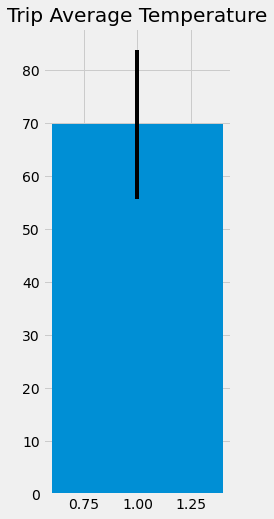

In [47]:
plt.figure(figsize=(3, 8))
x=1
plt.bar(x, tavg, yerr = (tmax-tmin), align="center")
plt.title("Trip Average Temperature")

### Daily Average Rainfall

In [35]:
# Join both reference tables
weather_join = session.query(Measurement, Station).filter(Measurement.station == Station.station).limit(10).all()

In [70]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# Join both reference tables
trip_start = '2011-05-15'
trip_end = '2018-05-24'
last_year_start = (dt.strptime(trip_start, "%Y-%m-%d")-timedelta(days=365)).strftime("%Y-%m-%d")
last_end_date = (dt.strptime(trip_end, "%Y-%m-%d")-timedelta(days=365)).strftime("%Y-%m-%d")
sel = session.query(func.sum(Measurement.prcp), Station.station, Station.name, Station.latitude,
                    Station.longitude, Station.elevation).\
                    filter(Measurement.date >= last_year_start).\
                    filter(Measurement.date <= last_end_date).\
                    group_by(Measurement.station == Station.station).order_by(func.sum(Measurement.prcp).desc())

In [71]:
total_prescip = pd.DataFrame(sel, columns = ["Total Rainfall", "Station ID", "Station Name", "Station Latitude", "Station Longitude", "Station Elevation"])
total_prescip

,Total Rainfall,Station ID,Station Name,Station Latitude,Station Longitude,Station Elevation
0,21988.96,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.3152,-157.9992,0.9
1,2748.62,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4


In [72]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [75]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals_list = []
# Set the start and end date of the trip
trip_start = '2011-05-15'
trip_end = '2018-05-24'
last_year_start = (dt.strptime(trip_start, "%Y-%m-%d"))
last_end_date = (dt.strptime(trip_end, "%Y-%m-%d"))
# Use the start and end date to create a range of dates
date_range = last_end_date - last_year_start
# Stip off the year and save a list of %m-%d strings
month_day = []
                 
# Loop through the list of %m-%d strings and calculate the normals for each date
for date in range(date_range.days +1):
    dates = last_year_start + timedelta(days = date)
    month_day.append(dt.strftime(dates, "%m-%d"))
for date in month_day:
    normals_list.append(daily_normals(date)[0])
print(normals_list)
                 

[(63.0, 73.69090909090909, 79.0), (68.0, 74.37931034482759, 80.0), (68.0, 74.45, 79.0), (68.0, 74.10714285714286, 82.0), (65.0, 73.80701754385964, 79.0), (68.0, 73.89655172413794, 79.0), (64.0, 72.96428571428571, 80.0), (64.0, 74.45614035087719, 80.0), (68.0, 74.94827586206897, 87.0), (67.0, 73.94827586206897, 79.0), (68.0, 74.27586206896552, 79.0), (65.0, 74.03636363636363, 82.0), (65.0, 74.49090909090908, 80.0), (67.0, 74.27777777777777, 82.0), (64.0, 74.19607843137256, 80.0), (69.0, 74.33333333333333, 81.0), (68.0, 74.4, 81.0), (64.0, 74.6140350877193, 81.0), (65.0, 74.4, 81.0), (65.0, 74.03448275862068, 80.0), (65.0, 73.81818181818181, 81.0), (68.0, 74.85454545454546, 81.0), (70.0, 75.17543859649123, 80.0), (68.0, 75.07142857142857, 81.0), (70.0, 75.58620689655173, 81.0), (69.0, 75.15254237288136, 81.0), (68.0, 75.14285714285714, 81.0), (69.0, 76.01960784313725, 84.0), (66.0, 75.66666666666667, 83.0), (68.0, 75.66666666666667, 81.0), (69.0, 75.62711864406779, 81.0), (67.0, 75.40350

In [77]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals_list, columns=["tmin", "tavg", "tmax"])
normals_df["date"] = month_day
normals_df.set_index("date", inplace = True)
normals_df

,tmin,tavg,tmax
date,,,
05-15,63.0,73.690909,79.0
05-16,68.0,74.379310,80.0
05-17,68.0,74.450000,79.0
05-18,68.0,74.107143,82.0
05-19,65.0,73.807018,79.0
...,...,...,...
05-20,68.0,73.896552,79.0
05-21,64.0,72.964286,80.0
05-22,64.0,74.456140,80.0


<AxesSubplot:xlabel='date'>

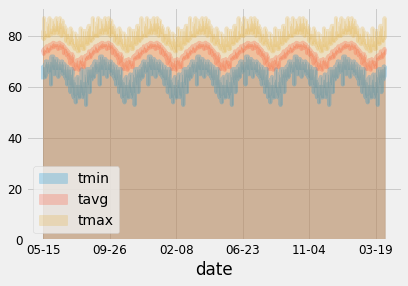

In [81]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind="area", stacked= False, alpha= .25, fontsize = 12)